In [1]:
import pandas as pd
import numpy as np
from stellargraph import StellarGraph

base_path = "/home/colombelli/Documents/datasets/acgt/kidney/stellargraph/"
edges_file = base_path+"patients_edges.csv"
features_file = base_path+"patients_features.csv"
classes_file = base_path+"patients_classes.csv"

In [2]:
# Imports required for following the tutorial: 
# https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gat-node-classification.html

import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Loading data and building the StellarGraph object

df_patients = pd.read_csv(edges_file)
df_features = pd.read_csv(features_file, index_col=0)
df_classes = pd.read_csv(classes_file, index_col=0).sample(frac=1)

In [4]:
G = StellarGraph(edges=df_patients, nodes=df_features)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 201, Edges: 553

 Node types:
  default: [201]
    Features: float32 vector, length 700
    Edge types: default-default->default

 Edge types:
    default-default->default: [553]
        Weights: range=[0.700181, 1], mean=0.874138, std=0.116815
        Features: none


In [5]:
# Splitting data into train/validation/test

train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

series_classes = df_classes['class']
series_classes = series_classes.sample(frac=1)

train_subjects, test_subjects = model_selection.train_test_split(
    series_classes, test_size=1-train_ratio, stratify=series_classes)

val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, test_size=test_ratio/(test_ratio + validation_ratio), stratify=test_subjects)

print("Len train: ", len(train_subjects))
print("Len validation: ", len(val_subjects))
print("Len test: ", len(test_subjects))
print("\nLen everything: ", len(val_subjects)+len(test_subjects)+len(train_subjects))

Len train:  140
Len validation:  30
Len test:  31

Len everything:  201


In [6]:
from collections import Counter
counter = Counter(train_subjects)
counter

Counter({'stage3': 22,
         'stage1': 64,
         'stage4': 22,
         'control': 17,
         'stage2': 15})

In [7]:
from collections import Counter
counter = Counter(val_subjects)
counter

Counter({'stage1': 14, 'stage4': 5, 'stage3': 5, 'stage2': 3, 'control': 3})

In [8]:
from collections import Counter
counter = Counter(test_subjects)
counter

Counter({'stage4': 5, 'stage2': 3, 'stage1': 14, 'control': 4, 'stage3': 5})

In [9]:
"""
target_encoding.inverse_transform(np.array([[1,0,0,0,0], 
                                            [0,1,0,0,0],
                                            [0,0,1,0,0],
                                            [0,0,0,1,0],
                                            [0,0,0,0,1]]))
"""

'\ntarget_encoding.inverse_transform(np.array([[1,0,0,0,0], \n                                            [0,1,0,0,0],\n                                            [0,0,1,0,0],\n                                            [0,0,0,1,0],\n                                            [0,0,0,0,1]]))\n'

In [10]:
# weights logic taken from: https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
num_samples = 0
for cls in counter:
    num_samples += counter[cls]
num_classes = len(counter)

w_control = num_samples / (num_classes * counter['control'])
w_s1 = num_samples / (num_classes * counter['stage1'])
w_s2 = num_samples / (num_classes * counter['stage2'])
w_s3 = num_samples / (num_classes * counter['stage3'])
w_s4 = num_samples / (num_classes * counter['stage4'])

weights = np.array([w_control, w_s1, w_s2, w_s3, w_s4])
weights

array([1.55      , 0.44285714, 2.06666667, 1.24      , 1.24      ])

## The cell below is used to downsample the training data. Skip it if this is not the goal

In [11]:
"""
train_subjects_downsample = train_subjects.loc[train_subjects == 'stage1'][0:50].append(
            train_subjects.loc[train_subjects == 'stage2'][0:50]).append(
            train_subjects.loc[train_subjects == 'stage3'][0:50]).append(
            train_subjects.loc[train_subjects == 'stage4'][0:50]).append(
            train_subjects.loc[train_subjects == 'control'][0:50])

train_subjects=train_subjects_downsample
Counter(train_subjects_downsample)
"""

"\ntrain_subjects_downsample = train_subjects.loc[train_subjects == 'stage1'][0:50].append(\n            train_subjects.loc[train_subjects == 'stage2'][0:50]).append(\n            train_subjects.loc[train_subjects == 'stage3'][0:50]).append(\n            train_subjects.loc[train_subjects == 'stage4'][0:50]).append(\n            train_subjects.loc[train_subjects == 'control'][0:50])\n\ntrain_subjects=train_subjects_downsample\nCounter(train_subjects_downsample)\n"

In [12]:
# Converting to one-hot encoding

target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [13]:
generator = FullBatchNodeGenerator(G, method="gat")
train_gen = generator.flow(train_subjects.index, train_targets)

In [14]:
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.core import Dense, Activation, Dropout

nb_classes = 5
input_dim = df_features.loc[train_subjects.index].values.shape[1]

model = Sequential()
model.add(Dense(64, input_dim=input_dim))
model.add(Activation('elu'))
model.add(Dropout(0.15))
model.add(Dense(64))
model.add(Activation('elu'))
model.add(Dropout(0.15))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), 
              metrics=["acc", metrics.AUC(curve="ROC"), metrics.AUC(curve="PR")])

X_train = df_features.loc[train_subjects.index].values
y_train = train_targets

X_val = df_features.loc[val_subjects.index].values
y_val = val_targets

print("Training...")
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_val, y_val), batch_size=8, verbose=2)

Training...
Epoch 1/500
18/18 - 1s - loss: 4.4388 - acc: 0.2214 - auc: 0.5505 - auc_1: 0.2237 - val_loss: 2.6214 - val_acc: 0.5000 - val_auc: 0.6507 - val_auc_1: 0.3927
Epoch 2/500
18/18 - 0s - loss: 3.0545 - acc: 0.3571 - auc: 0.6258 - auc_1: 0.2960 - val_loss: 1.8075 - val_acc: 0.4000 - val_auc: 0.6656 - val_auc_1: 0.3958
Epoch 3/500
18/18 - 0s - loss: 2.4886 - acc: 0.3071 - auc: 0.6622 - auc_1: 0.3337 - val_loss: 1.7218 - val_acc: 0.4333 - val_auc: 0.7417 - val_auc_1: 0.4601
Epoch 4/500
18/18 - 0s - loss: 2.2139 - acc: 0.4071 - auc: 0.7020 - auc_1: 0.3952 - val_loss: 1.5772 - val_acc: 0.5333 - val_auc: 0.7618 - val_auc_1: 0.4928
Epoch 5/500
18/18 - 0s - loss: 2.1051 - acc: 0.3857 - auc: 0.6937 - auc_1: 0.4193 - val_loss: 1.5071 - val_acc: 0.5333 - val_auc: 0.7647 - val_auc_1: 0.5058
Epoch 6/500
18/18 - 0s - loss: 1.9237 - acc: 0.3857 - auc: 0.7275 - auc_1: 0.4478 - val_loss: 1.5141 - val_acc: 0.5000 - val_auc: 0.7749 - val_auc_1: 0.5181
Epoch 7/500
18/18 - 0s - loss: 1.7669 - acc: 0

Epoch 53/500
18/18 - 0s - loss: 0.2811 - acc: 0.9357 - auc: 0.9946 - auc_1: 0.9803 - val_loss: 1.3717 - val_acc: 0.5333 - val_auc: 0.8222 - val_auc_1: 0.6099
Epoch 54/500
18/18 - 0s - loss: 0.2509 - acc: 0.9571 - auc: 0.9963 - auc_1: 0.9864 - val_loss: 1.4968 - val_acc: 0.4667 - val_auc: 0.8114 - val_auc_1: 0.5788
Epoch 55/500
18/18 - 0s - loss: 0.3781 - acc: 0.8643 - auc: 0.9834 - auc_1: 0.9439 - val_loss: 1.4203 - val_acc: 0.5333 - val_auc: 0.8137 - val_auc_1: 0.5892
Epoch 56/500
18/18 - 0s - loss: 0.3183 - acc: 0.9143 - auc: 0.9906 - auc_1: 0.9715 - val_loss: 1.4051 - val_acc: 0.6000 - val_auc: 0.8176 - val_auc_1: 0.6059
Epoch 57/500
18/18 - 0s - loss: 0.2496 - acc: 0.9357 - auc: 0.9970 - auc_1: 0.9888 - val_loss: 1.4523 - val_acc: 0.5333 - val_auc: 0.8208 - val_auc_1: 0.5937
Epoch 58/500
18/18 - 0s - loss: 0.2779 - acc: 0.9143 - auc: 0.9939 - auc_1: 0.9792 - val_loss: 1.4069 - val_acc: 0.5667 - val_auc: 0.8144 - val_auc_1: 0.5965
Epoch 59/500
18/18 - 0s - loss: 0.2926 - acc: 0.9143

Epoch 105/500
18/18 - 0s - loss: 0.0940 - acc: 0.9714 - auc: 0.9995 - auc_1: 0.9980 - val_loss: 1.7791 - val_acc: 0.5000 - val_auc: 0.7789 - val_auc_1: 0.5277
Epoch 106/500
18/18 - 0s - loss: 0.1329 - acc: 0.9500 - auc: 0.9986 - auc_1: 0.9944 - val_loss: 1.8516 - val_acc: 0.5000 - val_auc: 0.7937 - val_auc_1: 0.5135
Epoch 107/500
18/18 - 0s - loss: 0.0836 - acc: 0.9786 - auc: 0.9998 - auc_1: 0.9990 - val_loss: 1.7113 - val_acc: 0.5667 - val_auc: 0.8124 - val_auc_1: 0.5468
Epoch 108/500
18/18 - 0s - loss: 0.0896 - acc: 0.9929 - auc: 0.9999 - auc_1: 0.9997 - val_loss: 1.7643 - val_acc: 0.5000 - val_auc: 0.7997 - val_auc_1: 0.5472
Epoch 109/500
18/18 - 0s - loss: 0.0648 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 1.8038 - val_acc: 0.4667 - val_auc: 0.8022 - val_auc_1: 0.5581
Epoch 110/500
18/18 - 0s - loss: 0.0830 - acc: 0.9857 - auc: 0.9997 - auc_1: 0.9990 - val_loss: 1.7675 - val_acc: 0.5000 - val_auc: 0.8032 - val_auc_1: 0.5510
Epoch 111/500
18/18 - 0s - loss: 0.0805 - acc:

Epoch 157/500
18/18 - 0s - loss: 0.0333 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 2.1245 - val_acc: 0.4667 - val_auc: 0.7796 - val_auc_1: 0.5201
Epoch 158/500
18/18 - 0s - loss: 0.0214 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 2.1082 - val_acc: 0.5000 - val_auc: 0.7712 - val_auc_1: 0.5219
Epoch 159/500
18/18 - 0s - loss: 0.0266 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 2.1710 - val_acc: 0.4667 - val_auc: 0.7757 - val_auc_1: 0.5216
Epoch 160/500
18/18 - 0s - loss: 0.0425 - acc: 0.9929 - auc: 0.9999 - auc_1: 0.9994 - val_loss: 2.0118 - val_acc: 0.5333 - val_auc: 0.8006 - val_auc_1: 0.5543
Epoch 161/500
18/18 - 0s - loss: 0.0291 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 2.0932 - val_acc: 0.5333 - val_auc: 0.7726 - val_auc_1: 0.5228
Epoch 162/500
18/18 - 0s - loss: 0.0317 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 2.1210 - val_acc: 0.5000 - val_auc: 0.7746 - val_auc_1: 0.5228
Epoch 163/500
18/18 - 0s - loss: 0.0566 - acc:

Epoch 209/500
18/18 - 0s - loss: 0.0285 - acc: 0.9929 - auc: 0.9999 - auc_1: 0.9997 - val_loss: 2.1435 - val_acc: 0.5667 - val_auc: 0.7860 - val_auc_1: 0.5316
Epoch 210/500
18/18 - 0s - loss: 0.0275 - acc: 0.9929 - auc: 1.0000 - auc_1: 0.9999 - val_loss: 2.3871 - val_acc: 0.5000 - val_auc: 0.7733 - val_auc_1: 0.5225
Epoch 211/500
18/18 - 0s - loss: 0.0179 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 2.2622 - val_acc: 0.5000 - val_auc: 0.7890 - val_auc_1: 0.5348
Epoch 212/500
18/18 - 0s - loss: 0.0254 - acc: 0.9929 - auc: 1.0000 - auc_1: 0.9998 - val_loss: 2.2747 - val_acc: 0.6000 - val_auc: 0.7769 - val_auc_1: 0.5288
Epoch 213/500
18/18 - 0s - loss: 0.0322 - acc: 0.9929 - auc: 0.9999 - auc_1: 0.9996 - val_loss: 2.2182 - val_acc: 0.5000 - val_auc: 0.7849 - val_auc_1: 0.5411
Epoch 214/500
18/18 - 0s - loss: 0.0355 - acc: 0.9857 - auc: 0.9999 - auc_1: 0.9998 - val_loss: 2.0105 - val_acc: 0.5333 - val_auc: 0.8031 - val_auc_1: 0.5661
Epoch 215/500
18/18 - 0s - loss: 0.0229 - acc:

Epoch 261/500
18/18 - 0s - loss: 0.0061 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 2.4698 - val_acc: 0.5000 - val_auc: 0.7869 - val_auc_1: 0.5216
Epoch 262/500
18/18 - 0s - loss: 0.0139 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 2.2178 - val_acc: 0.5667 - val_auc: 0.7808 - val_auc_1: 0.5369
Epoch 263/500
18/18 - 0s - loss: 0.0078 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 2.2886 - val_acc: 0.5000 - val_auc: 0.7946 - val_auc_1: 0.5453
Epoch 264/500
18/18 - 0s - loss: 0.0106 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 2.3614 - val_acc: 0.5000 - val_auc: 0.7922 - val_auc_1: 0.5423
Epoch 265/500
18/18 - 0s - loss: 0.0088 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 2.6734 - val_acc: 0.5000 - val_auc: 0.7726 - val_auc_1: 0.5081
Epoch 266/500
18/18 - 0s - loss: 0.0066 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 2.5836 - val_acc: 0.5000 - val_auc: 0.7862 - val_auc_1: 0.5323
Epoch 267/500
18/18 - 0s - loss: 0.0108 - acc:

Epoch 313/500
18/18 - 0s - loss: 0.0212 - acc: 0.9929 - auc: 1.0000 - auc_1: 0.9998 - val_loss: 2.6884 - val_acc: 0.5333 - val_auc: 0.7650 - val_auc_1: 0.5205
Epoch 314/500
18/18 - 0s - loss: 0.0079 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 2.5529 - val_acc: 0.5333 - val_auc: 0.7767 - val_auc_1: 0.5249
Epoch 315/500
18/18 - 0s - loss: 0.0147 - acc: 0.9929 - auc: 1.0000 - auc_1: 0.9999 - val_loss: 2.4872 - val_acc: 0.5000 - val_auc: 0.7763 - val_auc_1: 0.5218
Epoch 316/500
18/18 - 0s - loss: 0.0146 - acc: 0.9929 - auc: 1.0000 - auc_1: 0.9999 - val_loss: 2.7029 - val_acc: 0.5000 - val_auc: 0.7822 - val_auc_1: 0.5310
Epoch 317/500
18/18 - 0s - loss: 0.0083 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 2.7090 - val_acc: 0.5333 - val_auc: 0.7924 - val_auc_1: 0.5251
Epoch 318/500
18/18 - 0s - loss: 0.0061 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 2.5570 - val_acc: 0.5333 - val_auc: 0.7881 - val_auc_1: 0.5361
Epoch 319/500
18/18 - 0s - loss: 0.0077 - acc:

Epoch 365/500
18/18 - 0s - loss: 0.0020 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 2.8881 - val_acc: 0.5000 - val_auc: 0.7658 - val_auc_1: 0.5086
Epoch 366/500
18/18 - 0s - loss: 0.0023 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 2.9335 - val_acc: 0.4667 - val_auc: 0.7828 - val_auc_1: 0.5206
Epoch 367/500
18/18 - 0s - loss: 0.0047 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 3.0785 - val_acc: 0.5000 - val_auc: 0.7839 - val_auc_1: 0.5045
Epoch 368/500
18/18 - 0s - loss: 0.0010 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 3.1349 - val_acc: 0.4667 - val_auc: 0.7767 - val_auc_1: 0.5010
Epoch 369/500
18/18 - 0s - loss: 0.0016 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 3.0345 - val_acc: 0.5000 - val_auc: 0.7739 - val_auc_1: 0.4962
Epoch 370/500
18/18 - 0s - loss: 0.0016 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 3.0110 - val_acc: 0.5000 - val_auc: 0.7747 - val_auc_1: 0.4970
Epoch 371/500
18/18 - 0s - loss: 0.0016 - acc:

Epoch 417/500
18/18 - 0s - loss: 0.0246 - acc: 0.9929 - auc: 1.0000 - auc_1: 0.9999 - val_loss: 2.6012 - val_acc: 0.5333 - val_auc: 0.8031 - val_auc_1: 0.5481
Epoch 418/500
18/18 - 0s - loss: 0.0236 - acc: 0.9857 - auc: 0.9999 - auc_1: 0.9998 - val_loss: 2.2105 - val_acc: 0.6000 - val_auc: 0.8146 - val_auc_1: 0.5622
Epoch 419/500
18/18 - 0s - loss: 0.0079 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 2.5517 - val_acc: 0.6000 - val_auc: 0.7910 - val_auc_1: 0.5005
Epoch 420/500
18/18 - 0s - loss: 0.0042 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 2.6174 - val_acc: 0.6000 - val_auc: 0.8050 - val_auc_1: 0.5314
Epoch 421/500
18/18 - 0s - loss: 0.0045 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 2.4917 - val_acc: 0.5667 - val_auc: 0.8015 - val_auc_1: 0.5392
Epoch 422/500
18/18 - 0s - loss: 0.0095 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 2.4626 - val_acc: 0.4667 - val_auc: 0.7951 - val_auc_1: 0.5411
Epoch 423/500
18/18 - 0s - loss: 0.0047 - acc:

Epoch 469/500
18/18 - 0s - loss: 0.0220 - acc: 0.9929 - auc: 0.9999 - auc_1: 0.9996 - val_loss: 2.5503 - val_acc: 0.5667 - val_auc: 0.7843 - val_auc_1: 0.5251
Epoch 470/500
18/18 - 0s - loss: 0.0045 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 2.5917 - val_acc: 0.5667 - val_auc: 0.7814 - val_auc_1: 0.5352
Epoch 471/500
18/18 - 0s - loss: 0.0020 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 2.7278 - val_acc: 0.5333 - val_auc: 0.7829 - val_auc_1: 0.5362
Epoch 472/500
18/18 - 0s - loss: 0.0011 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 2.8178 - val_acc: 0.5333 - val_auc: 0.7815 - val_auc_1: 0.5317
Epoch 473/500
18/18 - 0s - loss: 0.0014 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 2.8525 - val_acc: 0.5333 - val_auc: 0.7843 - val_auc_1: 0.5354
Epoch 474/500
18/18 - 0s - loss: 0.0023 - acc: 1.0000 - auc: 1.0000 - auc_1: 1.0000 - val_loss: 2.7940 - val_acc: 0.5667 - val_auc: 0.7801 - val_auc_1: 0.5278
Epoch 475/500
18/18 - 0s - loss: 7.9831e-04 - 

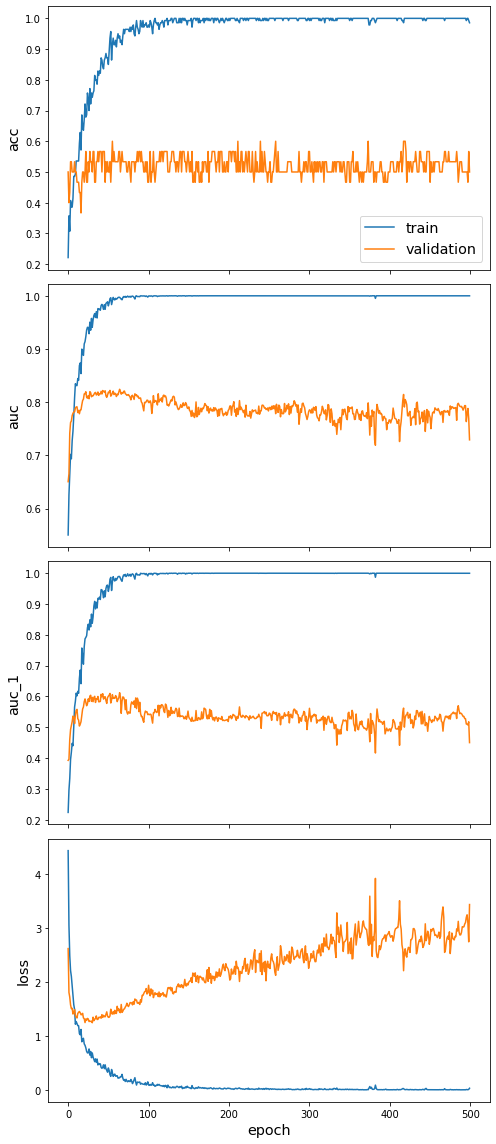

In [15]:
sg.utils.plot_history(history)

In [16]:
X_test = df_features.loc[test_subjects.index].values
y_test = test_targets

test_metrics = model.evaluate(X_test, y_test)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 16ms/step - loss: 2.1876 - acc: 0.5806 - auc: 0.8466 - auc_1: 0.7375

Test Set Metrics:
	loss: 2.1876
	acc: 0.5806
	auc: 0.8466
	auc_1: 0.7375


In [17]:
"""
A weighted version of categorical_crossentropy for keras (2.0.6). This lets you apply a weight to unbalanced classes.
@url: https://gist.github.com/wassname/ce364fddfc8a025bfab4348cf5de852d
@author: wassname
"""
from __future__ import print_function
from tensorflow import cast, int64, float32
from keras import backend as K


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy

    Variables:
        weights: numpy array of shape (C,) where C is the number of classes

    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """

    weights = K.variable(weights)

    def loss(y_true, y_pred):
        y_true = cast(y_true, dtype=float32)
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss

    return loss

In [18]:
gat = GAT(
    layer_sizes=[100, train_targets.shape[1]],
    activations=["elu", "softmax"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.1,
    attn_dropout=0.1,
    normalize=None,
)

x_inp, predictions = gat.in_out_tensors()

In [19]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.0001),
    loss=losses.categorical_crossentropy,
    #loss=weighted_categorical_crossentropy(np.array([1,1,1,1,1])),#weights/(max(weights)+1)),#weights),#weights/(max(weights)+1)),
    metrics=["acc", metrics.AUC(curve="ROC"), metrics.AUC(curve="PR")],
)

val_gen = generator.flow(val_subjects.index, val_targets)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("logs"):
    os.makedirs("logs")
    
es_callback = EarlyStopping(
    monitor="val_acc", patience=500#200
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)

In [21]:
history = model.fit(
    train_gen,
    epochs=500,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/500
1/1 - 3s - loss: 9.0114 - acc: 0.0786 - auc_2: 0.4396 - auc_3: 0.1652 - val_loss: 5.6576 - val_acc: 0.1000 - val_auc_2: 0.4735 - val_auc_3: 0.1765
Epoch 2/500
1/1 - 0s - loss: 6.4358 - acc: 0.1357 - auc_2: 0.4934 - auc_3: 0.1868 - val_loss: 4.0454 - val_acc: 0.2667 - val_auc_2: 0.6218 - val_auc_3: 0.2964
Epoch 3/500
1/1 - 0s - loss: 5.6888 - acc: 0.2786 - auc_2: 0.5648 - auc_3: 0.2522 - val_loss: 4.2092 - val_acc: 0.4333 - val_auc_2: 0.6472 - val_auc_3: 0.3558
Epoch 4/500
1/1 - 0s - loss: 5.1001 - acc: 0.3857 - auc_2: 0.6434 - auc_3: 0.3211 - val_loss: 4.4215 - val_acc: 0.4333 - val_auc_2: 0.6667 - val_auc_3: 0.3440
Epoch 5/500
1/1 - 0s - loss: 5.1942 - acc: 0.3714 - auc_2: 0.6393 - auc_3: 0.3315 - val_loss: 4.2038 - val_acc: 0.4333 - val_auc_2: 0.6753 - val_auc_3: 0.3683
Epoch 6/500
1/1 - 0s - loss: 5.3109 - acc: 0.3571 - auc_2: 0.6396 - auc_3: 0.3058 - val_loss: 3.6418 - val_acc: 0.3667 - val_auc_2: 0.6444 - val_auc_3: 0.3314
Epoch 7/500
1/1 - 0s - loss: 5.1183 - acc: 0.2

Epoch 53/500
1/1 - 0s - loss: 2.2752 - acc: 0.5214 - auc_2: 0.8041 - auc_3: 0.5649 - val_loss: 1.8216 - val_acc: 0.5667 - val_auc_2: 0.8282 - val_auc_3: 0.5882
Epoch 54/500
1/1 - 0s - loss: 2.0270 - acc: 0.5429 - auc_2: 0.8186 - auc_3: 0.5891 - val_loss: 1.8263 - val_acc: 0.6333 - val_auc_2: 0.8389 - val_auc_3: 0.5978
Epoch 55/500
1/1 - 0s - loss: 2.3837 - acc: 0.5429 - auc_2: 0.8062 - auc_3: 0.5703 - val_loss: 1.9086 - val_acc: 0.6333 - val_auc_2: 0.8258 - val_auc_3: 0.6071
Epoch 56/500
1/1 - 0s - loss: 1.8637 - acc: 0.5929 - auc_2: 0.8467 - auc_3: 0.6266 - val_loss: 2.0663 - val_acc: 0.6000 - val_auc_2: 0.8267 - val_auc_3: 0.5816
Epoch 57/500
1/1 - 0s - loss: 1.8888 - acc: 0.6214 - auc_2: 0.8542 - auc_3: 0.6516 - val_loss: 2.1949 - val_acc: 0.6000 - val_auc_2: 0.8203 - val_auc_3: 0.5850
Epoch 58/500
1/1 - 0s - loss: 2.1979 - acc: 0.5357 - auc_2: 0.8299 - auc_3: 0.5833 - val_loss: 2.2317 - val_acc: 0.6000 - val_auc_2: 0.8233 - val_auc_3: 0.5862
Epoch 59/500
1/1 - 0s - loss: 2.0647 - a

Epoch 105/500
1/1 - 0s - loss: 1.2339 - acc: 0.6429 - auc_2: 0.8986 - auc_3: 0.7575 - val_loss: 1.8391 - val_acc: 0.6333 - val_auc_2: 0.8215 - val_auc_3: 0.6386
Epoch 106/500
1/1 - 0s - loss: 1.0453 - acc: 0.6571 - auc_2: 0.9214 - auc_3: 0.7882 - val_loss: 1.8392 - val_acc: 0.6667 - val_auc_2: 0.8242 - val_auc_3: 0.6483
Epoch 107/500
1/1 - 0s - loss: 1.3769 - acc: 0.6786 - auc_2: 0.8845 - auc_3: 0.7021 - val_loss: 1.8163 - val_acc: 0.6000 - val_auc_2: 0.8450 - val_auc_3: 0.6533
Epoch 108/500
1/1 - 0s - loss: 1.5574 - acc: 0.6357 - auc_2: 0.8720 - auc_3: 0.6832 - val_loss: 1.8030 - val_acc: 0.6333 - val_auc_2: 0.8444 - val_auc_3: 0.6469
Epoch 109/500
1/1 - 0s - loss: 1.4148 - acc: 0.6857 - auc_2: 0.8908 - auc_3: 0.7432 - val_loss: 1.7570 - val_acc: 0.6333 - val_auc_2: 0.8556 - val_auc_3: 0.6441
Epoch 110/500
1/1 - 0s - loss: 1.2662 - acc: 0.6714 - auc_2: 0.8895 - auc_3: 0.7297 - val_loss: 1.7400 - val_acc: 0.6000 - val_auc_2: 0.8551 - val_auc_3: 0.6379
Epoch 111/500
1/1 - 0s - loss: 1.4

Epoch 156/500
1/1 - 0s - loss: 1.1913 - acc: 0.6857 - auc_2: 0.9051 - auc_3: 0.7367 - val_loss: 1.8217 - val_acc: 0.6333 - val_auc_2: 0.8544 - val_auc_3: 0.6471
Epoch 157/500
1/1 - 0s - loss: 0.9258 - acc: 0.7357 - auc_2: 0.9246 - auc_3: 0.7900 - val_loss: 1.8695 - val_acc: 0.6333 - val_auc_2: 0.8519 - val_auc_3: 0.6456
Epoch 158/500
1/1 - 0s - loss: 0.7758 - acc: 0.7571 - auc_2: 0.9463 - auc_3: 0.8557 - val_loss: 1.8915 - val_acc: 0.6333 - val_auc_2: 0.8511 - val_auc_3: 0.6445
Epoch 159/500
1/1 - 0s - loss: 1.2121 - acc: 0.6929 - auc_2: 0.9078 - auc_3: 0.7620 - val_loss: 1.8884 - val_acc: 0.6333 - val_auc_2: 0.8490 - val_auc_3: 0.6415
Epoch 160/500
1/1 - 0s - loss: 0.9289 - acc: 0.7214 - auc_2: 0.9312 - auc_3: 0.8155 - val_loss: 1.8657 - val_acc: 0.6333 - val_auc_2: 0.8469 - val_auc_3: 0.6383
Epoch 161/500
1/1 - 0s - loss: 1.0816 - acc: 0.6643 - auc_2: 0.9108 - auc_3: 0.7625 - val_loss: 1.8732 - val_acc: 0.6333 - val_auc_2: 0.8465 - val_auc_3: 0.6399
Epoch 162/500
1/1 - 0s - loss: 1.0

Epoch 207/500
1/1 - 0s - loss: 0.8768 - acc: 0.7000 - auc_2: 0.9286 - auc_3: 0.8227 - val_loss: 1.8967 - val_acc: 0.6000 - val_auc_2: 0.8428 - val_auc_3: 0.6293
Epoch 208/500
1/1 - 0s - loss: 0.7501 - acc: 0.7357 - auc_2: 0.9486 - auc_3: 0.8458 - val_loss: 1.8903 - val_acc: 0.5667 - val_auc_2: 0.8415 - val_auc_3: 0.6260
Epoch 209/500
1/1 - 0s - loss: 1.0585 - acc: 0.7214 - auc_2: 0.9101 - auc_3: 0.7563 - val_loss: 1.9291 - val_acc: 0.6000 - val_auc_2: 0.8378 - val_auc_3: 0.6314
Epoch 210/500
1/1 - 0s - loss: 0.7234 - acc: 0.7286 - auc_2: 0.9461 - auc_3: 0.8460 - val_loss: 1.9956 - val_acc: 0.5667 - val_auc_2: 0.8394 - val_auc_3: 0.6370
Epoch 211/500
1/1 - 0s - loss: 0.8484 - acc: 0.7786 - auc_2: 0.9374 - auc_3: 0.8387 - val_loss: 2.0731 - val_acc: 0.6000 - val_auc_2: 0.8317 - val_auc_3: 0.6391
Epoch 212/500
1/1 - 0s - loss: 0.7392 - acc: 0.7500 - auc_2: 0.9543 - auc_3: 0.8685 - val_loss: 2.1189 - val_acc: 0.6333 - val_auc_2: 0.8312 - val_auc_3: 0.6161
Epoch 213/500
1/1 - 0s - loss: 0.8

Epoch 258/500
1/1 - 0s - loss: 0.7400 - acc: 0.7571 - auc_2: 0.9509 - auc_3: 0.8623 - val_loss: 2.2361 - val_acc: 0.6000 - val_auc_2: 0.8178 - val_auc_3: 0.5993
Epoch 259/500
1/1 - 0s - loss: 0.7793 - acc: 0.7643 - auc_2: 0.9354 - auc_3: 0.8441 - val_loss: 2.2176 - val_acc: 0.6000 - val_auc_2: 0.8149 - val_auc_3: 0.5945
Epoch 260/500
1/1 - 0s - loss: 0.5868 - acc: 0.7929 - auc_2: 0.9616 - auc_3: 0.8882 - val_loss: 2.1553 - val_acc: 0.6000 - val_auc_2: 0.8135 - val_auc_3: 0.5920
Epoch 261/500
1/1 - 0s - loss: 0.7129 - acc: 0.7714 - auc_2: 0.9482 - auc_3: 0.8621 - val_loss: 2.0912 - val_acc: 0.5667 - val_auc_2: 0.8097 - val_auc_3: 0.5875
Epoch 262/500
1/1 - 0s - loss: 0.6710 - acc: 0.7714 - auc_2: 0.9561 - auc_3: 0.8758 - val_loss: 1.9956 - val_acc: 0.5667 - val_auc_2: 0.8296 - val_auc_3: 0.6154
Epoch 263/500
1/1 - 0s - loss: 0.5001 - acc: 0.7857 - auc_2: 0.9689 - auc_3: 0.9061 - val_loss: 1.9184 - val_acc: 0.5667 - val_auc_2: 0.8474 - val_auc_3: 0.6133
Epoch 264/500
1/1 - 0s - loss: 0.6

Epoch 309/500
1/1 - 0s - loss: 0.6018 - acc: 0.8214 - auc_2: 0.9604 - auc_3: 0.8949 - val_loss: 1.9787 - val_acc: 0.5333 - val_auc_2: 0.8382 - val_auc_3: 0.6025
Epoch 310/500
1/1 - 0s - loss: 0.7145 - acc: 0.7929 - auc_2: 0.9532 - auc_3: 0.8735 - val_loss: 1.9012 - val_acc: 0.5000 - val_auc_2: 0.8383 - val_auc_3: 0.6203
Epoch 311/500
1/1 - 0s - loss: 0.6635 - acc: 0.7643 - auc_2: 0.9498 - auc_3: 0.8571 - val_loss: 1.8597 - val_acc: 0.5000 - val_auc_2: 0.8410 - val_auc_3: 0.6170
Epoch 312/500
1/1 - 0s - loss: 0.5245 - acc: 0.8429 - auc_2: 0.9688 - auc_3: 0.8993 - val_loss: 1.8137 - val_acc: 0.5333 - val_auc_2: 0.8390 - val_auc_3: 0.6061
Epoch 313/500
1/1 - 0s - loss: 0.5375 - acc: 0.8143 - auc_2: 0.9654 - auc_3: 0.9048 - val_loss: 1.8275 - val_acc: 0.5333 - val_auc_2: 0.8406 - val_auc_3: 0.6081
Epoch 314/500
1/1 - 0s - loss: 0.5125 - acc: 0.8357 - auc_2: 0.9697 - auc_3: 0.9115 - val_loss: 1.8694 - val_acc: 0.5333 - val_auc_2: 0.8438 - val_auc_3: 0.5999
Epoch 315/500
1/1 - 0s - loss: 0.7

Epoch 360/500
1/1 - 0s - loss: 0.5414 - acc: 0.8214 - auc_2: 0.9716 - auc_3: 0.9078 - val_loss: 2.0724 - val_acc: 0.5000 - val_auc_2: 0.8288 - val_auc_3: 0.6176
Epoch 361/500
1/1 - 0s - loss: 0.5550 - acc: 0.8000 - auc_2: 0.9679 - auc_3: 0.9003 - val_loss: 2.0682 - val_acc: 0.5000 - val_auc_2: 0.8276 - val_auc_3: 0.6187
Epoch 362/500
1/1 - 0s - loss: 0.5212 - acc: 0.8214 - auc_2: 0.9660 - auc_3: 0.9081 - val_loss: 2.0607 - val_acc: 0.5000 - val_auc_2: 0.8272 - val_auc_3: 0.6170
Epoch 363/500
1/1 - 0s - loss: 0.5450 - acc: 0.8357 - auc_2: 0.9702 - auc_3: 0.9055 - val_loss: 2.0481 - val_acc: 0.5000 - val_auc_2: 0.8256 - val_auc_3: 0.6141
Epoch 364/500
1/1 - 0s - loss: 0.6056 - acc: 0.8214 - auc_2: 0.9604 - auc_3: 0.8883 - val_loss: 2.0416 - val_acc: 0.5000 - val_auc_2: 0.8268 - val_auc_3: 0.6119
Epoch 365/500
1/1 - 0s - loss: 0.5044 - acc: 0.8214 - auc_2: 0.9703 - auc_3: 0.9130 - val_loss: 2.0315 - val_acc: 0.5000 - val_auc_2: 0.8263 - val_auc_3: 0.6132
Epoch 366/500
1/1 - 0s - loss: 0.5

Epoch 411/500
1/1 - 0s - loss: 0.4047 - acc: 0.8357 - auc_2: 0.9811 - auc_3: 0.9369 - val_loss: 2.0199 - val_acc: 0.5333 - val_auc_2: 0.8167 - val_auc_3: 0.5616
Epoch 412/500
1/1 - 0s - loss: 0.6150 - acc: 0.7786 - auc_2: 0.9604 - auc_3: 0.8794 - val_loss: 2.0336 - val_acc: 0.5333 - val_auc_2: 0.8256 - val_auc_3: 0.5631
Epoch 413/500
1/1 - 0s - loss: 0.5063 - acc: 0.8357 - auc_2: 0.9733 - auc_3: 0.9225 - val_loss: 2.0433 - val_acc: 0.5333 - val_auc_2: 0.8249 - val_auc_3: 0.5608
Epoch 414/500
1/1 - 0s - loss: 0.3876 - acc: 0.8429 - auc_2: 0.9824 - auc_3: 0.9416 - val_loss: 2.0759 - val_acc: 0.5333 - val_auc_2: 0.8147 - val_auc_3: 0.5632
Epoch 415/500
1/1 - 0s - loss: 0.4560 - acc: 0.8286 - auc_2: 0.9761 - auc_3: 0.9296 - val_loss: 2.1105 - val_acc: 0.5333 - val_auc_2: 0.8149 - val_auc_3: 0.5673
Epoch 416/500
1/1 - 0s - loss: 0.5275 - acc: 0.8143 - auc_2: 0.9722 - auc_3: 0.9104 - val_loss: 2.1208 - val_acc: 0.5333 - val_auc_2: 0.8132 - val_auc_3: 0.5594
Epoch 417/500
1/1 - 0s - loss: 0.4

Epoch 462/500
1/1 - 0s - loss: 0.5742 - acc: 0.8143 - auc_2: 0.9649 - auc_3: 0.9042 - val_loss: 2.0314 - val_acc: 0.5333 - val_auc_2: 0.8126 - val_auc_3: 0.5864
Epoch 463/500
1/1 - 0s - loss: 0.4384 - acc: 0.8571 - auc_2: 0.9737 - auc_3: 0.9223 - val_loss: 2.0375 - val_acc: 0.5333 - val_auc_2: 0.8108 - val_auc_3: 0.5803
Epoch 464/500
1/1 - 0s - loss: 0.3651 - acc: 0.8643 - auc_2: 0.9834 - auc_3: 0.9452 - val_loss: 2.0637 - val_acc: 0.5333 - val_auc_2: 0.8194 - val_auc_3: 0.5836
Epoch 465/500
1/1 - 0s - loss: 0.6464 - acc: 0.7929 - auc_2: 0.9525 - auc_3: 0.8650 - val_loss: 2.1240 - val_acc: 0.5000 - val_auc_2: 0.8104 - val_auc_3: 0.5797
Epoch 466/500
1/1 - 0s - loss: 0.5160 - acc: 0.8143 - auc_2: 0.9663 - auc_3: 0.9074 - val_loss: 2.1947 - val_acc: 0.5000 - val_auc_2: 0.8042 - val_auc_3: 0.5665
Epoch 467/500
1/1 - 0s - loss: 0.4043 - acc: 0.8500 - auc_2: 0.9829 - auc_3: 0.9463 - val_loss: 2.2448 - val_acc: 0.5333 - val_auc_2: 0.7926 - val_auc_3: 0.5583
Epoch 468/500
1/1 - 0s - loss: 0.4

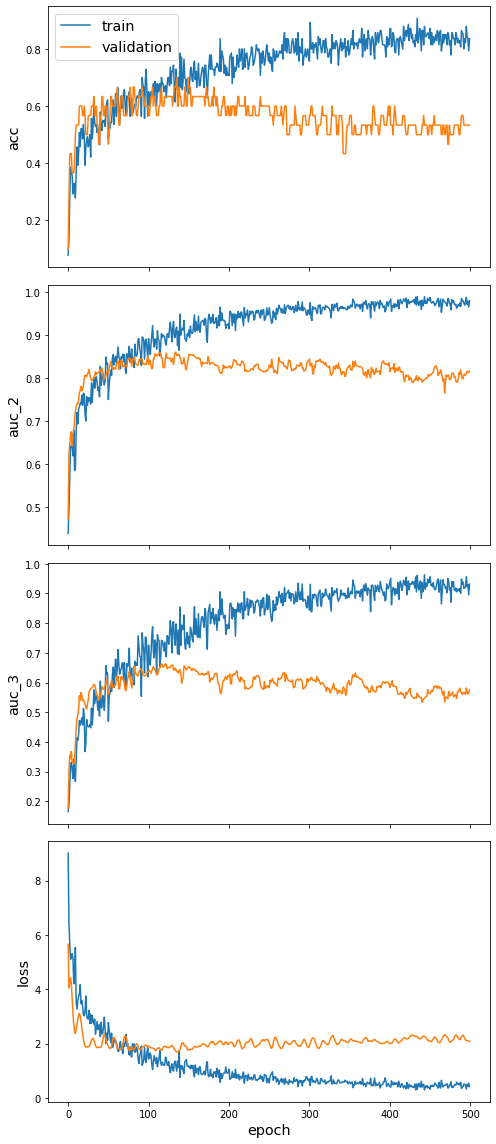

In [22]:
sg.utils.plot_history(history)

In [23]:
model.load_weights("logs/best_model.h5")
test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 40ms/step - loss: 1.6880 - acc: 0.4839 - auc_2: 0.8312 - auc_3: 0.5903

Test Set Metrics:
	loss: 1.6880
	acc: 0.4839
	auc_2: 0.8312
	auc_3: 0.5903


In [24]:
all_nodes = series_classes.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [25]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())
df = pd.DataFrame({"Predicted": node_predictions, "True": series_classes})

print(df['True'].value_counts(), "\n")
df['Predicted'].value_counts()

stage1     92
stage4     32
stage3     32
control    24
stage2     21
Name: True, dtype: int64 



stage1     100
stage4      31
control     25
stage2      23
stage3      22
Name: Predicted, dtype: int64

In [26]:
for component in G.connected_components():
    print(len(component))

89
12
5
3
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [27]:
G.node_degrees()

defaultdict(int,
            {'TCGA.B0.5690.01': 2,
             'TCGA.G6.A8L8.01': 1,
             'TCGA.B8.A54G.01': 1,
             'TCGA.B0.5698.01': 5,
             'TCGA.B4.5377.01': 9,
             'TCGA.CZ.4864.01': 1,
             'TCGA.B0.5693.01': 5,
             'TCGA.A3.A8OX.01': 1,
             'TCGA.A3.A6NN.01': 1,
             'TCGA.B0.5695.01': 6,
             'TCGA.EU.5904.01': 8,
             'TCGA.G6.A8L6.01': 2,
             'TCGA.G6.A8L7.01': 1,
             'TCGA.B8.A54H.01': 7,
             'TCGA.CZ.5469.11': 19,
             'TCGA.EU.5906.01': 12,
             'TCGA.B0.5402.11': 10,
             'TCGA.B0.4706.01': 1,
             'TCGA.B8.A7U6.01': 6,
             'TCGA.B4.5835.01': 1,
             'TCGA.CW.5583.01': 4,
             'TCGA.B0.5400.01': 1,
             'TCGA.B8.5549.01': 1,
             'TCGA.CJ.6030.01': 1,
             'TCGA.CZ.5454.11': 19,
             'TCGA.CZ.5467.01': 1,
             'TCGA.B0.5402.01': 1,
             'TCGA.CW.5581.01': 1,

## Correlation distribution among patients

array([[<AxesSubplot:title={'center':'weight'}>]], dtype=object)

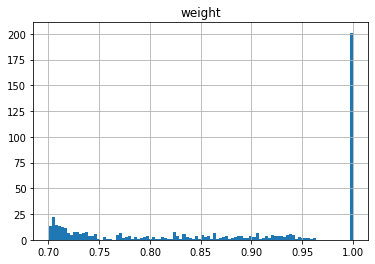

In [28]:
df_patients.hist(column='weight', bins=100)